In [33]:
import pandas as pd
import os

# Folders containing tournament results and KenPom data
results_folder = "data/results"
kenpom_folder = "data/kenpom"

results_data = []
kenpom_data = []

# Load all tournament results and tag with the year
for file in os.listdir(results_folder):
    if file.endswith(".csv"):
        year = int(file.split("_")[0])
        df = pd.read_csv(os.path.join(results_folder, file))
        df["Year"] = year
        results_data.append(df)

# Load all KenPom files and tag with the year
for file in os.listdir(kenpom_folder):
    if file.endswith(".csv"):
        year = int(file.split("_")[0])
        df = pd.read_csv(os.path.join(kenpom_folder, file))
        df["Year"] = year
        kenpom_data.append(df)

# Combine all years into single DataFrames
all_results = pd.concat(results_data, ignore_index=True)
all_kenpom = pd.concat(kenpom_data, ignore_index=True)

print(f"Loaded {all_results.shape[0]} tournament games")
print(f"Loaded {all_kenpom.shape[0]} KenPom team entries")

Loaded 630 tournament games
Loaded 3561 KenPom team entries


In [34]:
kenpom_clean = all_kenpom[["TeamName", "AdjEM", "seed", "Year"]].copy()

In [44]:
# Standardize team names to ensure consistency between tournament results and KenPom data
team_name_fixes = {
    "Michigan State": "Michigan St.",
    "Ohio State": "Ohio St.",
    "Iowa State": "Iowa St.",
    "Kansas State": "Kansas St.",
    "Oregon State": "Oregon St.",
    "Utah State": "Utah St.",
    "Colorado State": "Colorado St.",
    "New Mexico State": "New Mexico St.",
    "North Dakota State": "North Dakota St.",
    "South Dakota State": "South Dakota St.",
    "East Tennessee State": "East Tenn. St.",
    "Mississippi State": "Mississippi St.",
    "Arizona State": "Arizona St.",
    "Washington State": "Washington St.",
    "Weber State": "Weber St.",
    "Fresno State": "Fresno St.",
    "Kent State": "Kent St.",
    "Norfolk State": "Norfolk St.",
    "Morehead State": "Morehead St.",
    "Jacksonville State": "Jacksonville St.",
    "Alabama State": "Alabama St.",
    "Gardner-Webb": "Gardner Webb",
    "Long Beach State": "LBSU",
    "Col of Charleston": "Charleston",
    "Texas A&M-CC": "Texas A&M Corpus Chris",
    "North Kentucky": "Northern Kentucky",
    "Eastern Wash.": "Eastern Washington",
    "Southern California": "USC",
    "Miami (Fla.)": "Miami FL",
    "Miami (FL)": "Miami FL",
    "Saint Mary’s": "Saint Mary's",
    "St. Mary’s": "Saint Mary's",
    "St. Peter’s": "Saint Peter's",
    "UConn": "Connecticut",
    "Ole Miss": "Mississippi",
    "FAU": "Florida Atlantic",
    "FDU": "Fairleigh Dickinson",
    "Hawai'i": "Hawaii",
    "Cal State Bakersfield": "CSU Bakersfield",
    "Cal State Fullerton": "CSU Fullerton",
    "S. Dakota St.": "South Dakota St.",
    "Grambling State": "Grambling",
    "McNeese": "McNeese St.",
    "SIU Edwardsville": "SIU Edwards.",
    "Omaha": "Nebraska Omaha",
    "Wichita State": "Wichita St.",
    "Georgia State": "Georgia St.",
    "NC State": "N.C. State",
    "San Diego State": "San Diego St.",
    "Little Rock": "Arkansas Little Rock",
    "Florida State": "Florida St.",
    "Murray State": "Murray St.",
    "Pitt": "Pittsburgh",
    "Oklahoma State": "Oklahoma St.",
    "CSU Bakersfield": "Cal St. Bakersfield",
    "East Tenn. St.": "East Tennessee St.",
    "CSU Fullerton": "Cal St. Fullerton",
    "Wright State": "Wright St.",
    "Pennsylvania": "Penn",
    "UCSB": "UC Santa Barbara",
    "LBSU": "Long Beach St.",
    "Grambling": "Grambling St.",
    "SIU Edwards.": "SIU Edwardsville"
}

all_results["Team_1"] = all_results["Team_1"].replace(team_name_fixes)
all_results["Team_2"] = all_results["Team_2"].replace(team_name_fixes)

print("Team name standardization applied.")

Team name standardization applied.


In [45]:
# Handle special cases where team naming changed for specific years

# NC State in 2015 & 2018 should match KenPom as "North Carolina St."
mask_old_nc = (all_results["Year"].isin([2015, 2018]))
all_results.loc[mask_old_nc & (all_results["Team_1"] == "N.C. State"), "Team_1"] = "North Carolina St."
all_results.loc[mask_old_nc & (all_results["Team_2"] == "N.C. State"), "Team_2"] = "North Carolina St."

# McNeese in 2024 should match KenPom as "McNeese St."
mask_mc_2024 = (all_results["Year"] == 2024)
all_results.loc[mask_mc_2024 & (all_results["Team_1"] == "McNeese"), "Team_1"] = "McNeese St."
all_results.loc[mask_mc_2024 & (all_results["Team_2"] == "McNeese"), "Team_2"] = "McNeese St."

# SIUE and McNeese in 2025 need updated tournament naming
mask_siu_2025 = (all_results["Year"] == 2025)
all_results.loc[mask_siu_2025 & (all_results["Team_1"] == "SIU Edwardsville"), "Team_1"] = "SIUE"
all_results.loc[mask_siu_2025 & (all_results["Team_2"] == "SIU Edwardsville"), "Team_2"] = "SIUE"
all_results.loc[mask_siu_2025 & (all_results["Team_1"] == "McNeese St."), "Team_1"] = "McNeese"
all_results.loc[mask_siu_2025 & (all_results["Team_2"] == "McNeese St."), "Team_2"] = "McNeese"

print("Year-specific naming fixes applied.")

Year-specific naming fixes applied.


In [46]:
# Keep only seeded teams (tournament teams) from KenPom
kenpom_tourney = kenpom_clean.dropna(subset=["seed"])

# Merge KenPom data for Team_1
merged_df = all_results.merge(
    kenpom_tourney.rename(columns={"TeamName": "Team_1", "AdjEM": "AdjEM_1", "seed": "Seed_1"}),
    how="left",
    on=["Team_1", "Year"]
)

# Merge KenPom data for Team_2
merged_df = merged_df.merge(
    kenpom_tourney.rename(columns={"TeamName": "Team_2", "AdjEM": "AdjEM_2", "seed": "Seed_2"}),
    how="left",
    on=["Team_2", "Year"]
)

# Remove any leftover duplicate columns (_x/_y from merges)
merged_df = merged_df.rename(columns={
    "Seed_1_y": "Seed_1",
    "Seed_2_y": "Seed_2"
}).drop(columns=["Seed_1_x", "Seed_2_x"], errors="ignore")

# Quick verification
print("Columns after merge:", merged_df.columns.tolist())
print("Sample rows:")
print(merged_df.sample(5))

# Check if any games are still missing seeds after cleaning
missing_seeds = merged_df[merged_df["Seed_1"].isna() | merged_df["Seed_2"].isna()]
print("Games missing seeds:", missing_seeds.shape[0])

Columns after merge: ['Year', 'Round', 'Team_1', 'Team_2', 'Winner', 'AdjEM_1', 'Seed_1', 'AdjEM_2', 'Seed_2']
Sample rows:
     Year        Round          Team_1        Team_2          Winner  AdjEM_1  \
299  2019  Round of 32          Auburn        Kansas          Auburn  23.3317   
502  2023   Final Four     Connecticut      Miami FL           UConn  25.3686   
550  2024  Round of 32       Creighton        Oregon       Creighton  23.3993   
179  2017     Sweet 16        Kentucky          UCLA        Kentucky  27.2664   
316  2021  Round of 64  Loyola Chicago  Georgia Tech  Loyola Chicago  23.7539   

     Seed_1  AdjEM_2  Seed_2  
299     5.0  20.7051     4.0  
502     4.0  14.9148     5.0  
550     3.0  13.4292    11.0  
179     2.0  22.9515     3.0  
316     8.0  18.5494     9.0  
Games missing seeds: 0


In [47]:
# Predict winners using two methods:
# - KenPom: team with higher AdjEM
# - Seed: team with lower (better) NCAA seed

merged_df["kenpom_pred"] = merged_df.apply(
    lambda row: row["Team_1"] if row["AdjEM_1"] > row["AdjEM_2"] else row["Team_2"],
    axis=1
)

merged_df["seed_pred"] = merged_df.apply(
    lambda row: row["Team_1"] if row["Seed_1"] < row["Seed_2"] else row["Team_2"],
    axis=1
)

# Flag games where KenPom and seeding disagreed
merged_df["methods_disagree"] = merged_df["kenpom_pred"] != merged_df["seed_pred"]

In [48]:
# Filter to only games where KenPom and NCAA seeds disagreed
disagreement_games = merged_df[merged_df["methods_disagree"]]

# Show how many disagreement games occurred
print("Total disagreement games:", disagreement_games.shape[0])

Total disagreement games: 59


In [49]:
# Evaluate who was correct in disagreement games
disagreement_games = disagreement_games.copy()  # avoid SettingWithCopyWarning

# Add correctness flags
disagreement_games["kenpom_correct"] = disagreement_games["kenpom_pred"] == disagreement_games["Winner"]
disagreement_games["seed_correct"]   = disagreement_games["seed_pred"]   == disagreement_games["Winner"]

# Count totals
total_disagreements = len(disagreement_games)
kenpom_right = disagreement_games["kenpom_correct"].sum()
seed_right   = disagreement_games["seed_correct"].sum()

print(f"KenPom correct: {kenpom_right}/{total_disagreements} ({kenpom_right/total_disagreements:.1%})")
print(f"Seed correct:   {seed_right}/{total_disagreements} ({seed_right/total_disagreements:.1%})")

KenPom correct: 26/59 (44.1%)
Seed correct:   22/59 (37.3%)


In [50]:
# Build a summary table comparing KenPom vs Seeds
summary = pd.DataFrame({
    "Method": ["KenPom", "Seed"],
    "Correct Picks": [kenpom_right, seed_right],
    "Total Disagreements": [total_disagreements, total_disagreements],
    "Accuracy": [
        round(kenpom_right / total_disagreements, 3),
        round(seed_right / total_disagreements, 3)
    ]
})

print(summary)

   Method  Correct Picks  Total Disagreements  Accuracy
0  KenPom             26                   59     0.441
1    Seed             22                   59     0.373


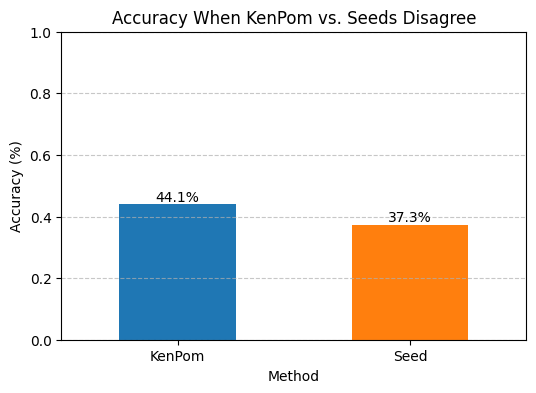

In [51]:
import matplotlib.pyplot as plt

# Bar chart: Accuracy when KenPom vs. Seeds disagree
ax = summary.plot(
    kind="bar",
    x="Method",
    y="Accuracy",
    legend=False,
    rot=0,
    color=["#1f77b4", "#ff7f0e"],  # optional colors
    figsize=(6,4)
)

plt.title("Accuracy When KenPom vs. Seeds Disagree")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 1)  # keep scale 0–1 for clarity
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add text labels above bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1%}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=10)

plt.show()

In [52]:
# Identify notable disagreement outcomes
kenpom_wins = disagreement_games[
    (disagreement_games["kenpom_correct"]) & (~disagreement_games["seed_correct"])
][["Year", "Round", "Team_1", "Team_2", "Winner", "kenpom_pred", "seed_pred"]]

seed_wins = disagreement_games[
    (~disagreement_games["kenpom_correct"]) & (disagreement_games["seed_correct"])
][["Year", "Round", "Team_1", "Team_2", "Winner", "kenpom_pred", "seed_pred"]]

print("KenPom correct, Seeds wrong (first 10):")
print(kenpom_wins.head(10))

print("\nSeeds correct, KenPom wrong (first 10):")
print(seed_wins.head(10))

KenPom correct, Seeds wrong (first 10):
     Year        Round         Team_1      Team_2         Winner  \
35   2015  Round of 32  West Virginia    Maryland  West Virginia   
47   2015  Round of 32           Utah  Georgetown           Utah   
77   2016  Round of 64            VCU  Oregon St.            VCU   
92   2016  Round of 64        Gonzaga  Seton Hall        Gonzaga   
93   2016  Round of 64       Syracuse      Dayton       Syracuse   
94   2016  Round of 64         Butler  Texas Tech         Butler   
108  2016  Round of 32        Gonzaga        Utah        Gonzaga   
120  2016  Elite Eight       Oklahoma      Oregon       Oklahoma   
124  2016   Final Four      Villanova    Oklahoma      Villanova   
139  2017  Round of 64         Xavier    Maryland         Xavier   

       kenpom_pred   seed_pred  
35   West Virginia    Maryland  
47            Utah  Georgetown  
77             VCU  Oregon St.  
92         Gonzaga  Seton Hall  
93        Syracuse      Dayton  
94          B